# Uniform linear grating coupler

Grating couplers are optical components used to efficiently couple light between optical fibers (or free-space beams) and integrated photonic waveguides. They consist of a periodic structure—typically etched onto the surface of a photonic chip—that diffracts incoming light into the waveguide mode (or vice versa). Grating couplers are widely used in silicon photonics due to their ease of fabrication, compatibility with planar processes, and ability to support wafer-scale testing. 

The simplest form of the grating coupler is the uniform linear grating coupler. In this notebook, we demonstrate the design workflow of such a device based on the silicon on insulator (SOI) platform. Conventionally, the initial design starts in 2D for faster speed and lower cost. Once the grating coupler is optimized in 2D, we construct the 3D version and can then potentially perform additional optimization to enhance its coupling efficiency. 

<img src="img/grating_coupler_schematic.png" width="400" alt="Schematic of the grating coupler">

More advanced grating coupler designs, such as the [focusing apodized grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/FocusedApodGC/) and the [inverse designed grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd19ApodizedCoupler/), can be realized to achieve higher performance.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Initial Design in 2D

We start with the 2D design and aim to optimize its coupling efficiency as much as possible. This way, the design process is faster and costs fewer FlexCredits.

First define the wavelength range of interest.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Grating couplers are relatively narrow band device. Within the working bandwidth, the refractive indices of silicon and oxide don't change noticeably. Therefore, for simplicity we will just model them as nondispersive mediums. 

In [3]:
n_si = 3.47
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44
sio2 = td.Medium(permittivity=n_sio2**2)

Define geometry parameters. In this case, we have a silicon layer of 260 nm thickness. The grating will be partially etched with an etching depth of 160 nm. The filling fraction is set to be 80% in this case. A higher filling fraction will lead to a smaller gap size so this needs to be chosen according to the fabrication. The BOX layer has a thickness of 2 μm and the top oxide cladding has a thickness of 680 nm. 

In [4]:
t_si = 0.26  # thickness of the silicon layer
etch_depth = 0.16  # etching depth
ff = 0.8  # filling fraction of the grating
t_tox = 0.68  # top oxide layer thickness
t_box = 2  # bottom oxide layer thickness
n = 20  # number of grating teeth to create

The goal is to couple between a single-mode waveguide and a single-mode fiber with a mode field diameter of 10.8 μm at an angle of 14.5 degrees.

In [5]:
theta = np.deg2rad(14.5)  # fiber tilt angle
mfd = 10.8  # mode field diameter

inf_eff = 1e3  # effective infinity
buffer = 0.6 * lda0  # buffer spacing to pad the simulation domain

Next we define some [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) that are not changing in the design. This includes the top oxide layer, BOX layer, slab waveguide layer, etc. 

In [6]:
# create the top oxide layer
tox = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, t_tox)),
    medium=sio2,
)

# create the slab waveguide
slab_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(0, inf_eff, t_si)),
    medium=si,
)

# create the etched waveguide
etched_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(0, -inf_eff, 0), rmax=(inf_eff, inf_eff, t_si - etch_depth)),
    medium=si,
)

# create the bottom oxide layer
box = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -t_box), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# create the silicon substrate layer
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -t_box)
    ),
    medium=si,
)

To enable parameter sweeping in optimizing the design, we define a function that takes the design parameters as arguments and returns a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object. In the simulation, we use a [GaussianBeam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianBeam.html) source to represent the incident field from the single-mode fiber. A [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) is added on the waveguide to measure the coupling efficiency, which will be used as the figure of merit for our design optimization.

Since this simulation is 2D, the boundary condition is set to periodic in the $y$ direction.

In [7]:
def make_2d_sim(p: float, source_x: float) -> td.Simulation:
    """Function to create a 2D simulation given the grating period and source position"""

    source_gap = 0.5  # gap distance between the source and the top oxide

    # define a gaussian beam source
    source = td.GaussianBeam(
        size=(2 * mfd, td.inf, 0),
        center=[source_x, 0, t_tox + source_gap],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        angle_theta=theta,
        direction="-",
        waist_radius=mfd / 2,
        pol_angle=np.pi / 2,  # 90 degree polarization angle for TE polarization
    )

    # define a mode monitor to measure coupling efficiency
    mode_monitor = td.ModeMonitor(
        center=(-buffer / 2, 0, t_si / 2),
        size=(0, td.inf, 6 * t_si),
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1, target_neff=3.47),
        name="mode",
    )

    l_grating = n * p  # length of the grating region

    # create the grating geometries
    gratings = 0
    for i in range(n):
        gratings += td.Box(
            center=(ff * p / 2 + i * p, 0, t_si - etch_depth / 2), size=(p * ff, td.inf, etch_depth)
        )

    # create the grating structure
    gratings = td.Structure(geometry=gratings, medium=si)

    # create a box to represent the simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-buffer, 0, -t_box - buffer),
        rmax=(l_grating + buffer, 0, t_si + t_tox + buffer),
    )

    run_time = 1e-12  # simulation run time

    # construct simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=25, wavelength=lda0
        ),  # use a fine grid to ensure the small features are well resolved
        structures=[
            tox,
            gratings,
            etched_waveguide,
            slab_waveguide,
            box,
            substrate,
        ],
        sources=[source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.periodic(),  # set the boundary to periodic in y since it's a 2D simulation
            z=td.Boundary.pml(),
        ),
    )

    return sim

To visualize the simulation setup, we can create a dummy simulation and plot it. The plot shows the setup is correct. We have a grating with a tunable period and a Gaussian beam with a tunable position.

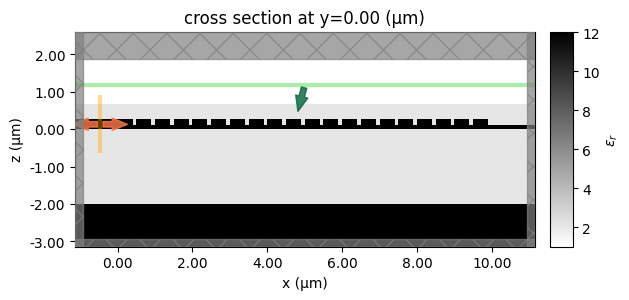

In [8]:
sim0 = make_2d_sim(p=0.5, source_x=5)
sim0.plot_eps(y=0, freq=freq0)
plt.show()

The next step is to determine the optimal grating period and source position. We can first get an estimate of the optimal grating period by using the grating equation

$$
\Lambda = \frac{\lambda_0}{n_{\text{eff}} - n_{\text{clad}} \sin \theta},
$$

where
- $\Lambda$ = grating period  
- $\lambda_0$ = free-space wavelength of the incident light  
- $n_{\text{eff}}$ = effective index of the guided mode in the waveguide  
- $n_{\text{clad}}$ = refractive index of the cladding 
- $\theta$ = angle of incidence

$n_{\text{eff}}$ can be approximated by 

$$
n_{\text{eff}} = f n_{etched} + (1-f) n_{unetched},
$$

where $f$ is the filling fraction, $n_{unetched}$ is the effective index of the unetched slab mode, and $n_{etched}$ is the effective index of the etched slab mode. We will calculate $n_{unetched}$ and $n_{etched}$ using our mode solver. The most convenient way of doing so would be to construct mode simulations from the dummy FDTD simulation. For the unetched slab mode, we specify the mode solving plane to be on the left side of the grating region. For the etched slab mode, we specify the plane to be on the right side of the grating region.

In [9]:
mode_unetched = td.ModeSimulation.from_simulation(
    sim0,
    mode_spec=td.ModeSpec(num_modes=1, target_neff=3.47),
    plane=td.Box(center=(-0.1, 0, 0), size=(0, td.inf, 5 * t_si)),
    freqs=[freq0],
)
data_unetched = web.run(simulation=mode_unetched, task_name="unetched")

mode_etched = mode_unetched.updated_copy(
    plane=td.Box(center=(n * 0.5 + 0.1, 0, 0), size=(0, td.inf, 5 * t_si))
)
data_etched = web.run(simulation=mode_etched, task_name="etched")

12:48:09 UTC Created task 'unetched' with task_id                               
             'mos-cc5486ef-a151-4fad-948d-d750b2005641' and task_type 'MODE'.

Output()

12:48:11 UTC Maximum FlexCredit cost: 0.004. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:48:13 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:48:56 UTC starting up solver

             running solver

             status = success

Output()

12:48:58 UTC loading simulation from simulation_data.hdf5

             Created task 'etched' with task_id                                 
             'mos-5625e4fb-c536-420e-b4e3-5afc9c91812c' and task_type 'MODE'.

Output()

12:49:00 UTC Maximum FlexCredit cost: 0.004. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:49:01 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:49:42 UTC starting up solver

             running solver

12:49:46 UTC status = success

Output()

12:49:48 UTC loading simulation from simulation_data.hdf5

After running the mode solving, we can extract the effective indices and hence calculate the appropriate grating period.

In [10]:
neff_unetch = (
    data_unetched.modes.n_eff.values.item()
)  # effective index of the slab mode of the unetched waveguide
neff_etch = (
    data_etched.modes.n_eff.values.item()
)  # effective index of the slab mode of the etched waveguide
theta_c = np.sin(theta) / n_sio2  # incident angle in the cladding
ff = 0.8  # filling fraction

# calculate the grating period
p = lda0 / (ff * neff_unetch + (1 - ff) * neff_etch - n_sio2 * np.sin(theta_c))

print(f"Calculated grating period is {p * 1e3:.0f} nm")

Calculated grating period is 608 nm


To optimize the design, we can perform a [parameter sweep](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan/) over the grating period and source position. To do so, we create a dictionary of simulations and then a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html). When running the batch, multiple simulations will be running in parallel, making the sweep very time-efficient.

In [11]:
p_list = np.linspace(0.60, 0.63, 7)
source_x_list = np.linspace(3, 5, 11)

sims_2d = {
    f"p={p:.2f};source_x={source_x:.2f}": make_2d_sim(p, source_x)
    for p in p_list
    for source_x in source_x_list
}

batch = web.Batch(simulations=sims_2d)
batch_results = batch.run(path_dir="data")

Output()

12:50:01 UTC Started working on Batch containing 44 tasks.

12:50:44 UTC Maximum FlexCredit cost: 1.100 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:03:07 UTC Batch complete.

Output()

After the sweep is finished, we can extract the coupling efficiency from the monitor data. 

In [12]:
ce = np.array(
    [
        [
            np.abs(
                batch_results[f"p={p:.2f};source_x={source_x:.2f}"]["mode"]
                .amps.sel(f=freq0, direction="-")
                .values.item()
            )
            ** 2
            for source_x in source_x_list
        ]
        for p in p_list
    ]
)

Plot the coupling efficiency as a function of period and source position in a false color map. 

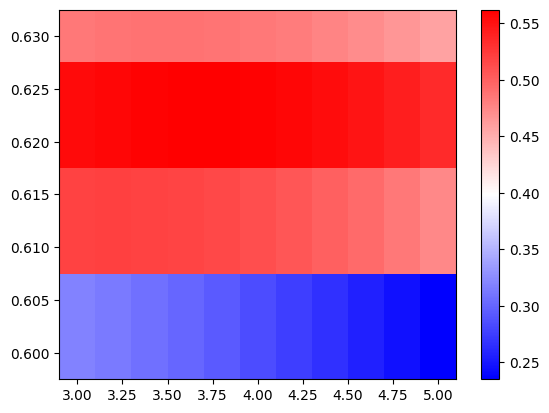

In [13]:
plt.pcolormesh(source_x_list, p_list, ce, cmap="bwr")
plt.colorbar()
plt.show()

From the result we can determine the optimal grating period and source position. 

In [14]:
i, j = np.unravel_index(np.argmax(ce), ce.shape)
best_p = p_list[i]
best_source_x = source_x_list[j]
best_ce = ce[i, j]

print(f"Optimal period is {best_p * 1e3} nm.")
print(f"Optimal source_x is {best_source_x} μm.")
print(f"Optimal coupling efficiency is {best_ce * 1e2:.2f}%, or {10 * np.log10(best_ce):.2f} dB.")

Optimal period is 620.0 nm.
Optimal source_x is 3.8 μm.
Optimal coupling efficiency is 56.21%, or -2.50 dB.


## 3D Design of the Grating Coupler

The 2D design shows promising results. Now we can convert it to 3D for verification and potentially further optimization. 

The single-mode waveguide has a width of 500 nm. The waveguide and the grating are connected via a linear taper. The longer the taper, the lower the loss in the taper region but the larger the footprint. Here we use a 50 μm linear taper with reasonably low loss. 

To enable additional optimization, we create a function similar to before. 

In [15]:
w_wg = 0.5  # waveguide width
w_grating = mfd  # grating width is set to the mode field diameter
l_taper = 50  # length of the linear taper


def make_3d_sim(p: float, source_x: float) -> td.Simulation:
    """Function to create a 2D simulation given the grating period and source position"""

    source_gap = 0.5

    # define a gaussian beam source
    source = td.GaussianBeam(
        size=(2 * mfd, 2 * mfd, 0),
        center=[source_x, 0, t_tox + source_gap],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        angle_theta=theta,
        direction="-",
        waist_radius=mfd / 2,
        pol_angle=np.pi / 2,  # 90 degree polarization angle for TE polarization
    )

    # define a mode monitor
    mode_monitor = td.ModeMonitor(
        center=(-l_taper - buffer / 2, 0, t_si / 2),
        size=(0, 4 * w_wg, 6 * t_si),
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1, target_neff=3.47),
        name="mode",
    )

    l_grating = n * p  # length of the grating region

    gratings = 0
    for i in range(n):
        gratings += td.Box(
            center=(ff * p / 2 + i * p, 0, t_si - etch_depth / 2),
            size=(p * ff, w_grating, etch_depth),
        )

    # create the grating structure
    gratings = td.Structure(geometry=gratings, medium=si)

    vertices = [
        (0, w_grating / 2),
        (0, -w_grating / 2),
        (-l_taper, -w_wg / 2),
        (-l_taper - 2 * buffer, -w_wg / 2),
        (-l_taper - 2 * buffer, w_wg / 2),
        (-l_taper, w_wg / 2),
    ]
    taper = td.Structure(
        geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_si)), medium=si
    )

    # create a box to represent the simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-buffer - l_taper, -w_grating / 2 - buffer, -t_box - buffer),
        rmax=(l_grating + buffer, w_grating / 2 + buffer, t_si + t_tox + buffer),
    )

    run_time = 2e-12  # simulation run time

    # construct simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=15, wavelength=lda0
        ),  # use a fine grid to ensure the small features are well resolved
        structures=[
            tox,
            gratings,
            etched_waveguide,
            taper,
            box,
            substrate,
        ],
        sources=[source],
        monitors=[mode_monitor],
        run_time=run_time,
        symmetry=(0, -1, 0),
    )

    return sim

Generate the simulation using the optimal parameters from the 2D design. 

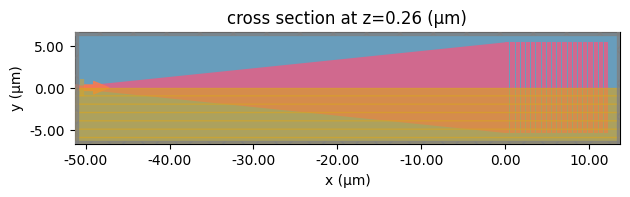

In [16]:
sim_3d = make_3d_sim(p=best_p, source_x=best_source_x)
sim_3d.plot(z=t_si)
plt.show()

Run the 3D simulation.

In [17]:
sim_data = web.run(simulation=sim_3d, task_name="3D_GC")

13:05:53 UTC Created task '3D_GC' with task_id                                  
             'fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=94214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=966395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\taskId]8;;\]8;id=94214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\=]8;;\]8;id=575951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\fdve]8;;\]8;id=94214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\-c11a8f5d-9a7]8;;\
             ]8;id=94214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\7-4774-80f0-a36fa6d3dab8']8;;\.

             Task folder: ]8;id=559074;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

13:05:55 UTC Maximum FlexCredit cost: 0.687. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

13:05:56 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:06:04 UTC status = preprocess

13:06:08 UTC starting up solver

             running solver

Output()

13:06:52 UTC status = success

             View simulation result at                                          
             ]8;id=590399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=573407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\taskId]8;;\]8;id=590399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\=]8;;\]8;id=555665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\fdve]8;;\]8;id=590399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\-c11a8f5d-9a7]8;;\
             ]8;id=590399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c11a8f5d-9a77-4774-80f0-a36fa6d3dab8\7-4774-80f0-a36fa6d3dab8']8;;\.

Output()

13:06:54 UTC loading simulation from simulation_data.hdf5

Plot the coupling efficiency as a function of wavelength. Compared to 2D, the coupling efficiency of -4 dB is slightly lower in 3D. This is because of two factors: 1. the taper introduces some loss during the mode size conversion down to the single-mode waveguide; 2. The optimal parameters in 2D can differ slightly from the optimal parameters in 3D. 

One can perform a parameter sweep similar to the 2D case to further optimize the design. For simplicity, we skip this part in this notebook.

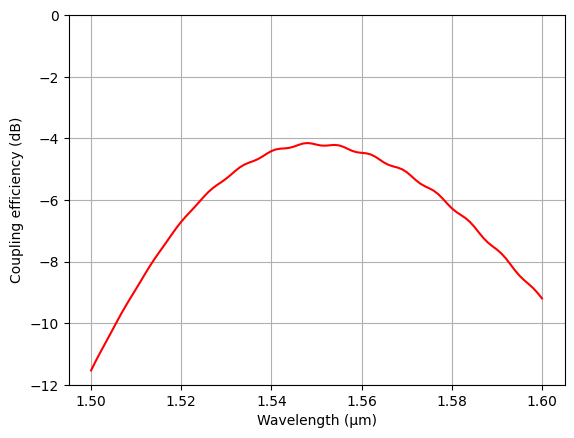

In [18]:
ce_3d = np.abs(sim_data["mode"].amps.sel(direction="-")) ** 2

plt.plot(ldas, 10 * np.log10(ce_3d), c="red")
plt.ylim(-12, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Coupling efficiency (dB)")
plt.grid()
plt.show()

## Final Remarks

In this notebook, we use the Gaussian beam as the source and use a mode monitor to measure the coupling efficiency. Due to reciprocity, one can use a mode source at the waveguide as excitation and then take the radiated field and do a mode overlap with a Gaussian profile to calculate the same value. In addition, in this setup, one can also perform near field to far field projection by using monitors like [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html) to investigate he radiation angle of the grating if that's of interest.

In the simulations we only focus on the coupling efficiency and hence only use a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) to measure the power of the fundamental mode in the waveguide. One can also add [FieldMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) in the simulations to help visualize the field distribution if needed. 